In [28]:
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from typing import List, Dict
from google.colab import drive

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
)
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer

In [29]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [30]:
%matplotlib inline

In [ ]:
from huggingface_hub import login
login("API_KEY")

In [32]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

GPU disponible: True
GPU: NVIDIA A100-SXM4-80GB
Memoria total: 79.25 GB


In [34]:
DATA_PATH = "/content/drive/MyDrive/atomi_conversations.jsonl"
raw_dataset = Dataset.from_json(DATA_PATH)

print(json.dumps(raw_dataset[0]['conversation'][:2], indent=2, ensure_ascii=False))
def analyze_conversations(dataset):
    stats = {
        'turns_per_conv': [],
        'assistant_responses': [],
        'user_messages': [],
    }
    
    for example in dataset:
        conv = example['conversation']
        stats['turns_per_conv'].append(len(conv))
        
        for turn in conv:
            if 'assistant' in turn:
                stats['assistant_responses'].append(turn['assistant'])
            if 'user' in turn:
                stats['user_messages'].append(turn['user'])
    
    return stats

stats = analyze_conversations(raw_dataset)

print(f"\nTotal conversaciones: {len(raw_dataset)}")
print(f"Respuestas assistant: {len(stats['assistant_responses'])}")
print(f"Mensajes user: {len(stats['user_messages'])}")

Generating train split: 0 examples [00:00, ? examples/s]

[
  {
    "assistant": "Buenos días, ¿todo bien o qué? Soy de Atomi.",
    "user": "Hola. ¿Cuánto cuestan esos productos?"
  },
  {
    "assistant": "Depende de lo que necesite sumercé. lo que pasa es que tenemos diferentes opciones.",
    "user": "Es que necesito algo económico."
  }
]

Total conversaciones: 5000
Respuestas assistant: 34020
Mensajes user: 34020


/tmp/ipython-input-4220408709.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([assistant_lengths, user_lengths], labels=['Assistant', 'User'])


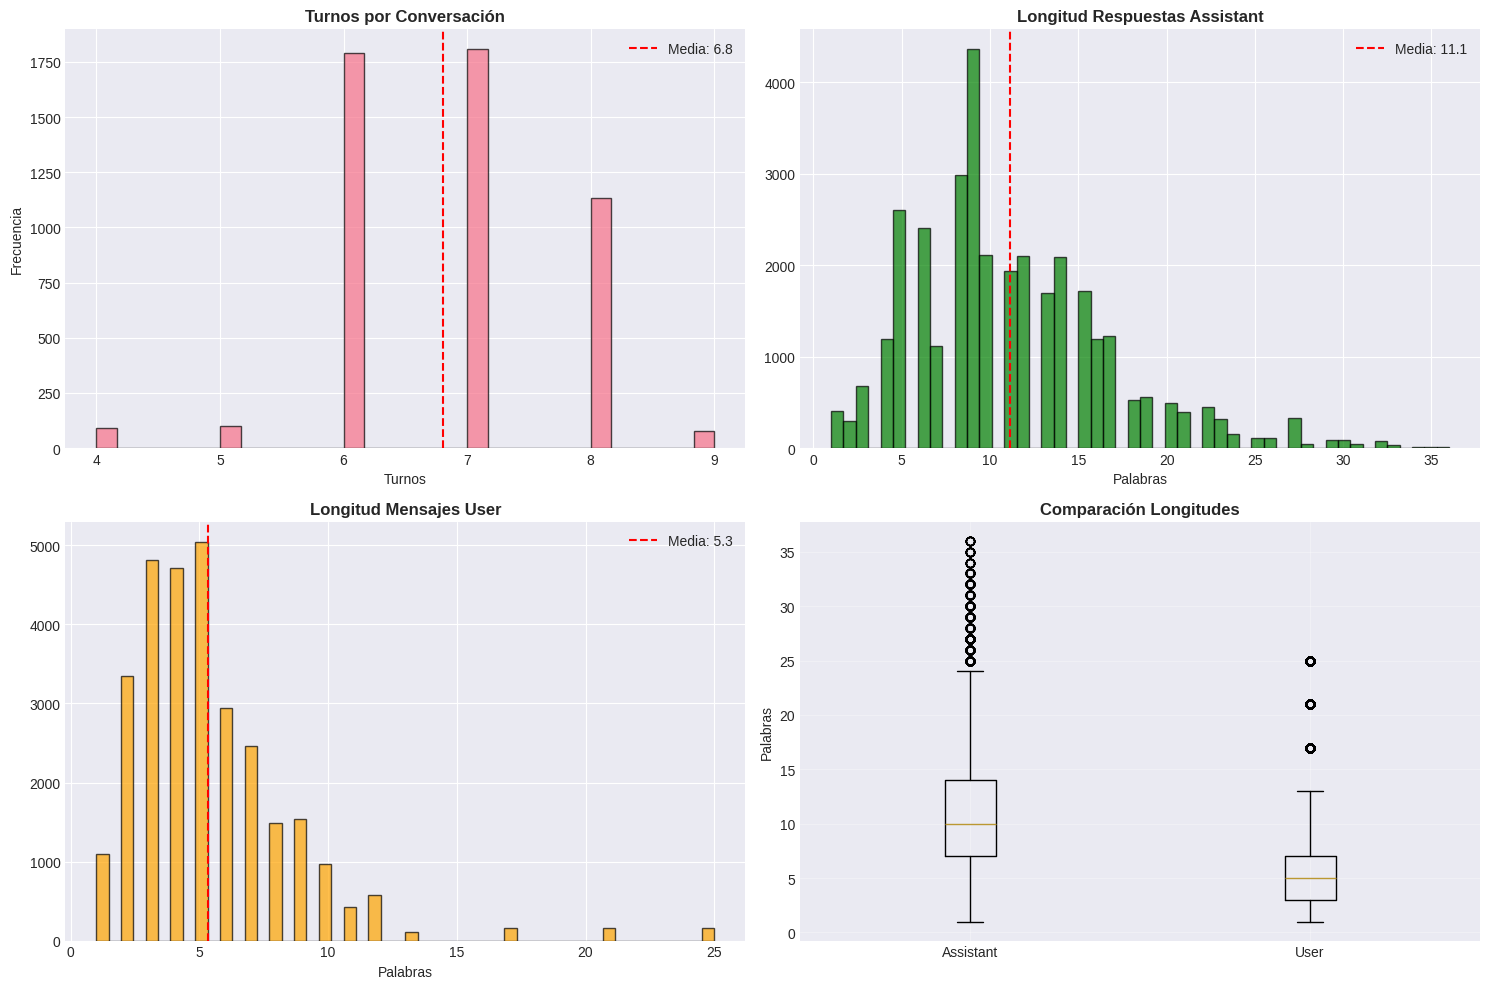

Assistant - Media: 11.11, Mediana: 10
User - Media: 5.33, Mediana: 5
Respuestas válidas: 33969 assistant, 30051 user


In [35]:
assistant_lengths = [len(text.split()) for text in stats['assistant_responses'] if text is not None]
user_lengths = [len(text.split()) for text in stats['user_messages'] if text is not None]

stats['assistant_responses'] = [text for text in stats['assistant_responses'] if text is not None]
stats['user_messages'] = [text for text in stats['user_messages'] if text is not None]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma turnos
axes[0, 0].hist(stats['turns_per_conv'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Turnos por Conversación', fontweight='bold')
axes[0, 0].set_xlabel('Turnos')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(np.mean(stats['turns_per_conv']), color='red', linestyle='--', label=f'Media: {np.mean(stats["turns_per_conv"]):.1f}')
axes[0, 0].legend()

# Longitud assistant
axes[0, 1].hist(assistant_lengths, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Longitud Respuestas Assistant', fontweight='bold')
axes[0, 1].set_xlabel('Palabras')
axes[0, 1].axvline(np.mean(assistant_lengths), color='red', linestyle='--', label=f'Media: {np.mean(assistant_lengths):.1f}')
axes[0, 1].legend()

# Longitud user
axes[1, 0].hist(user_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Longitud Mensajes User', fontweight='bold')
axes[1, 0].set_xlabel('Palabras')
axes[1, 0].axvline(np.mean(user_lengths), color='red', linestyle='--', label=f'Media: {np.mean(user_lengths):.1f}')
axes[1, 0].legend()

# Boxplot
axes[1, 1].boxplot([assistant_lengths, user_lengths], labels=['Assistant', 'User'])
axes[1, 1].set_title('Comparación Longitudes', fontweight='bold')
axes[1, 1].set_ylabel('Palabras')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/analisis_longitudes.png', dpi=300)
plt.show()

print(f"Assistant - Media: {np.mean(assistant_lengths):.2f}, Mediana: {np.median(assistant_lengths):.0f}")
print(f"User - Media: {np.mean(user_lengths):.2f}, Mediana: {np.median(user_lengths):.0f}")
print(f"Respuestas válidas: {len(assistant_lengths)} assistant, {len(user_lengths)} user")

  'sumercé': 10994 veces
  'vea': 944 veces
  'todo bien': 859 veces
  'listo': 560 veces
  'qué más': 60 veces

Top de palabras:
  sumercé: 10994
  productos: 10439
  atomi: 9619
  para: 6330
  días: 5062
  buenos: 5000
  bien: 4827
  perfecto: 4555
  cómo: 3338


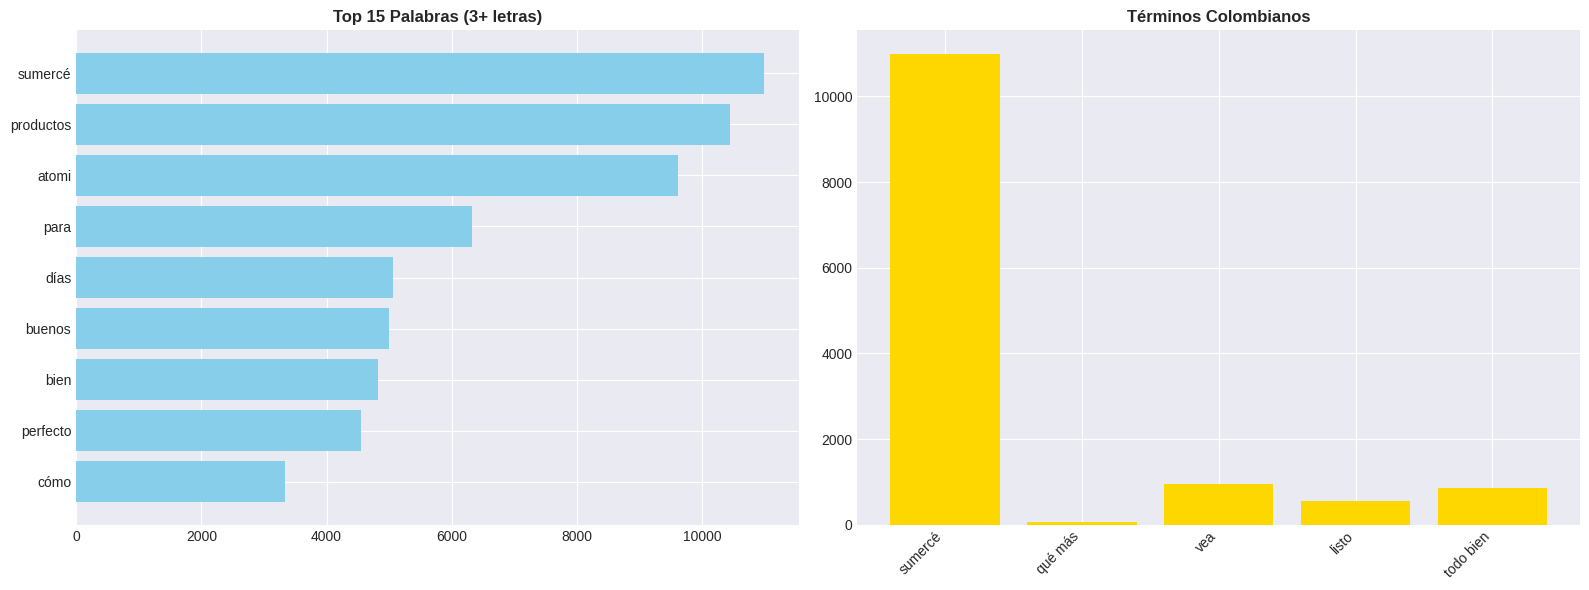

In [36]:
def extract_colombian_terms(texts):
    patterns = [
        r'\bsumercé\b', r'\bparce\b', r'\bchévere\b', r'\bberraco\b',
        r'\bpues\b', r'\bqué más\b', r'\bvea\b', r'\bmijo\b', r'\bmija\b',
        r'\blisto\b', r'\btodo bien\b', r'\ba la orden\b'
    ]
    
    all_text = ' '.join(texts).lower()
    colombian_counts = {}
    
    for pattern in patterns:
        matches = re.findall(pattern, all_text)
        if matches:
            term = pattern.replace(r'\b', '')
            colombian_counts[term] = len(matches)
    
    return colombian_counts

all_text = ' '.join(stats['assistant_responses']).lower()
words = re.findall(r'\b\w+\b', all_text)

word_freq = [(word, count) for word, count in Counter(words).most_common(20) if len(word) >= 4]
colombian_terms = extract_colombian_terms(stats['assistant_responses'])

for term, count in sorted(colombian_terms.items(), key=lambda x: x[1], reverse=True):
    print(f"  '{term}': {count} veces")

print("\nTop de palabras:")
for word, count in word_freq:
    print(f"  {word}: {count}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
words_list, counts_list = zip(*word_freq[:15])
axes[0].barh(range(len(words_list)), counts_list, color='skyblue')
axes[0].set_yticks(range(len(words_list)))
axes[0].set_yticklabels(words_list)
axes[0].set_title('Top 15 Palabras (3+ letras)', fontweight='bold')
axes[0].invert_yaxis()

if colombian_terms:
    col_terms = list(colombian_terms.keys())
    col_counts = list(colombian_terms.values())
    axes[1].bar(range(len(col_terms)), col_counts, color='#FFD700')
    axes[1].set_xticks(range(len(col_terms)))
    axes[1].set_xticklabels(col_terms, rotation=45, ha='right')
    axes[1].set_title('Términos Colombianos', fontweight='bold')

plt.tight_layout()
plt.show()

In [37]:
def format_conversation_for_training(conversation: List[Dict]) -> str:

    formatted_text = ""    
    for turn in conversation:
        if 'user' in turn:
            formatted_text += f"<|start_header_id|>user<|end_header_id|>\n\n{turn['user']}<|eot_id|>"
        if 'assistant' in turn:
            formatted_text += f"<|start_header_id|>assistant<|end_header_id|>\n\n{turn['assistant']}<|eot_id|>"
    
    return formatted_text

def process_dataset(example):
    return {"text": format_conversation_for_training(example['conversation'])}

formatted_dataset = raw_dataset.map(process_dataset, remove_columns=['conversation'])

print(f"formateado: {len(formatted_dataset)} ejemplos")
print("\nEjemplo:")
print(formatted_dataset[0]['text'][:400] + "...")

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

formateado: 5000 ejemplos

Ejemplo:
<|start_header_id|>user<|end_header_id|>

Hola. ¿Cuánto cuestan esos productos?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Buenos días, ¿todo bien o qué? Soy de Atomi.<|eot_id|><|start_header_id|>user<|end_header_id|>

Es que necesito algo económico.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Depende de lo que necesite sumercé. lo que pasa es que tenemos diferentes opcion...


In [38]:
train_test = formatted_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_test['test'].train_test_split(test_size=0.5, seed=SEED)

dataset_dict = DatasetDict({
    'train': train_test['train'],
    'validation': test_val['train'],
    'test': test_val['test']
})

print(f"Train: {len(dataset_dict['train'])}")
print(f"Validation: {len(dataset_dict['validation'])}")
print(f"Test: {len(dataset_dict['test'])}")

Train: 4000
Validation: 500
Test: 500


In [39]:
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [40]:
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Entrenables: {trainable:,}")
print(f"Total: {total:,}")
print(f"Porcentaje: {100 * trainable / total:.2f}%")

Entrenables: 41,943,040
Total: 4,582,543,360
Porcentaje: 0.92%


In [41]:
OUTPUT_DIR = "/content/drive/MyDrive/llama_colombiano_checkpoints"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    bf16=True,
    tf32=True,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=SEED,
)

print(f"Épocas: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch efectivo: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Épocas: 4
Batch size: 4
Gradient accumulation: 4
Learning rate: 0.0002
Batch efectivo: 16


In [42]:
def formatting_func(example):
    return example["text"]

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    processing_class=tokenizer,
    formatting_func=formatting_func,
)

trainer.create_model_card = lambda *args, **kwargs: None


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Applying formatting function to train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

In [43]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Epoch,Training Loss,Validation Loss
1,0.044870,0.045087
2,0.040123,0.040080
3,0.039224,0.039302
4,0.037814,0.039211


TrainOutput(global_step=1000, training_loss=0.12842621740698815, metrics={'train_runtime': 3287.4275, 'train_samples_per_second': 4.867, 'train_steps_per_second': 0.304, 'total_flos': 2.3584191024778445e+17, 'train_loss': 0.12842621740698815})

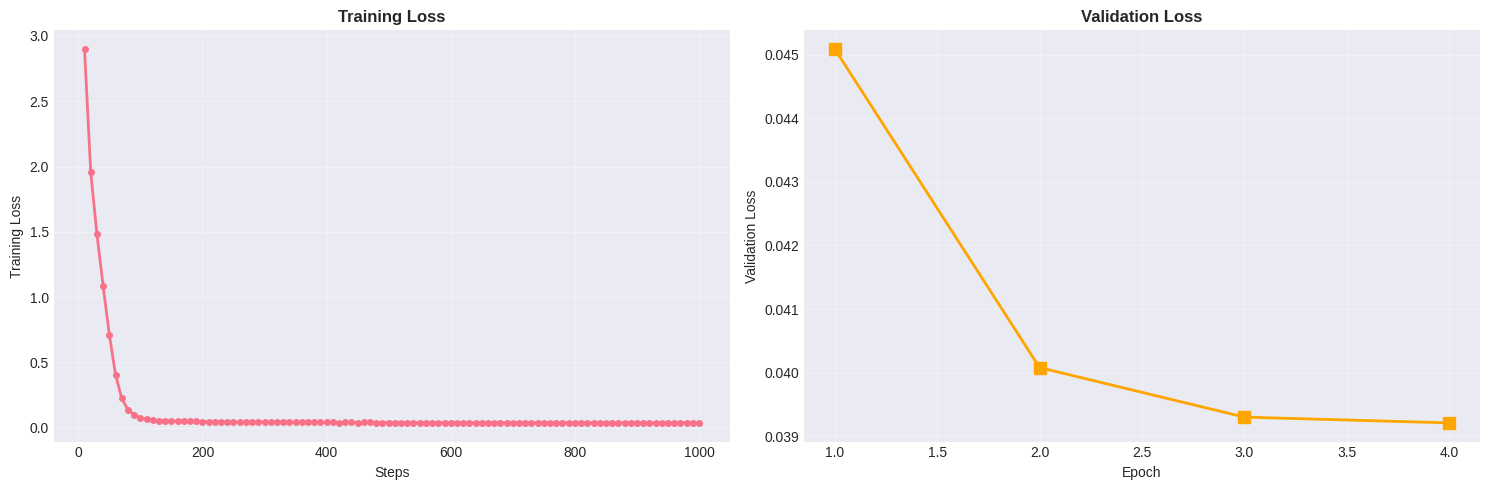

Train loss: 0.0378
Val loss: 0.0392
Mejor val loss: 0.0392


In [45]:
log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0].plot(steps, losses, marker='o', linewidth=2, markersize=4)
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

if eval_logs:
    epochs = [log['epoch'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    axes[1].plot(epochs, eval_losses, marker='s', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_title('Validation Loss', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if eval_logs:
    print(f"Train loss: {train_logs[-1]['loss']:.4f}")
    print(f"Val loss: {eval_logs[-1]['eval_loss']:.4f}")
    print(f"Mejor val loss: {min(log['eval_loss'] for log in eval_logs):.4f}")

In [51]:
def generate_response_with_history(conversation_history: list, max_new_tokens=150) -> str:

    prompt = ""
    for i, (user_msg, assistant_msg) in enumerate(conversation_history):
        prompt += f"<|start_header_id|>user<|end_header_id|>\n\n{user_msg}<|eot_id|>"
        
        if assistant_msg is not None:
            prompt += f"<|start_header_id|>assistant<|end_header_id|>\n\n{assistant_msg}<|eot_id|>"
        else:
            prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response.strip()

In [52]:
test_cases = [
    [
        ("Hola. ¿Cuánto cuestan esos productos?",  "Buenos días, ¿todo bien o qué? Soy de Atomi."),
        ("Pues me interesa, pero necesito algo económico.", None),
    ],
    [
        ("Hola, buenos días.",                     "Buenos días, ¿cómo le va? Le hablo de Atomi."),
        ("Ah ok, ¿y qué productos tienen?",        "Tenemos productos de aseo personal sumercé, de muy buena calidad."),
        ("Está muy caro para mí.",                 None),
    ],
    [
        ("Hola.",                                  "Buenas tardes, ¿todo bien? Soy de Atomi."),
        ("Déjeme pensarlo.",                       None),
    ],
]

for i, history in enumerate(test_cases, 1):
    last_user = history[-1][0]
    print(f"\n[Ejemplo {i}] Último mensaje user: '{last_user}'")
    response = generate_response_with_history(history)
    print(f"Assistant: {response}")
    print("-"*80)


[Ejemplo 1] Último mensaje user: 'Pues me interesa, pero necesito algo económico.'
Assistant: Depende de lo que necesite sumercé. mire, vea tenemos diferentes opciones.
--------------------------------------------------------------------------------

[Ejemplo 2] Último mensaje user: 'Está muy caro para mí.'
Assistant: mire le cuento depende de lo que necesite. lo que pasa es que tenemos diferentes opciones.
--------------------------------------------------------------------------------

[Ejemplo 3] Último mensaje user: 'Déjeme pensarlo.'
Assistant: Le contacto de Atomi, sumercé. Tenemos productos de cuidado de la piel que podrían interesarle.
--------------------------------------------------------------------------------


In [53]:
FINAL_MODEL_PATH = "/content/drive/MyDrive/llama_colombiano_LoRA"

trainer.model.save_pretrained(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

('/content/drive/MyDrive/llama_colombiano_LoRA/tokenizer_config.json',
 '/content/drive/MyDrive/llama_colombiano_LoRA/chat_template.jinja',
 '/content/drive/MyDrive/llama_colombiano_LoRA/tokenizer.json')